In [9]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import pandas as pd
import sklearn.gaussian_process
import patched_gpr
np.random.seed(0)

logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

In [10]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [11]:
project_dir = "../data/loess_iterative_train_bandwidth_models"
os.makedirs(project_dir, exist_ok=1)

In [12]:
n = 100
X = np.linspace(-50,50,n)
y = np.sin(X**2/100) + np.random.normal(0,0.06,n)

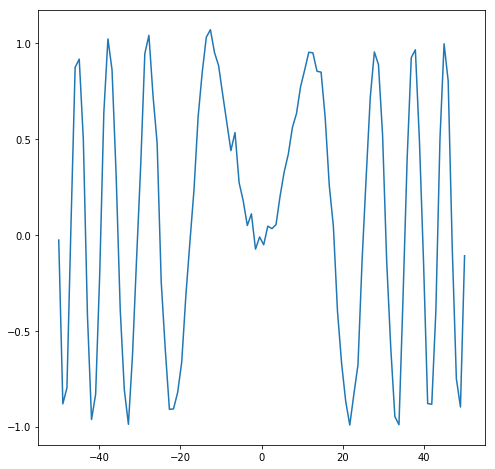

In [13]:
plt.plot(X,y)

In [116]:
models = local_models.local_models.LocalModels(sklearn.linear_model.LinearRegression())

In [117]:
models.fit(X.reshape(-1,1),y)

In [103]:
yy = models.predict(X.reshape(-1,1), weighted=True, kernel=kernel, r=kernel.support_radius())

In [127]:
kernel = local_models.local_models.GaussianKernel(bandwidth=n/1.5)
X_pred = np.linspace(np.min(X), np.max(X), 5*n)
y_pred = models.predict(X_pred.reshape(-1,1), weighted=True, kernel=kernel, r=kernel.support_radius())

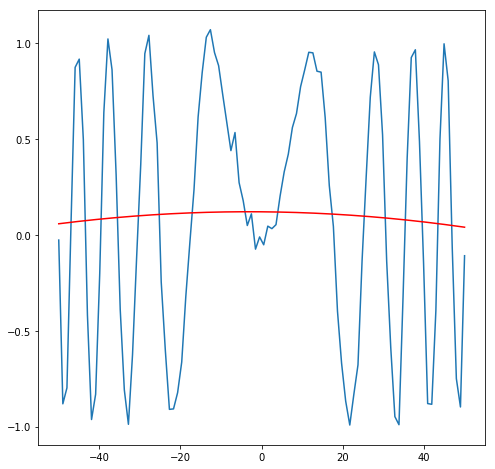

In [128]:
plt.plot(X,y)
plt.plot(X_pred, y_pred, c='r')

In [129]:
import importlib
importlib.reload(local_models.local_models)

<module 'local_models.local_models' from '/home/brown/python_packages/local_models/local_models/local_models.py'>

In [190]:
_,the_models = models.transform(X.reshape(-1,1), weighted=True, kernel=kernel, r=kernel.support_radius(), return_models=True)

In [195]:
def bandwidth_objective(bandwidth, X, y, fitted_models, index):
    kernel = local_models.local_models.GaussianKernel(bandwidth=bandwidth)
    iz, dz = index.query_radius(X.reshape(-1,1), kernel.support_radius(), return_distance=True)
    for i in range(dz.shape[0]):
        dz[i] = kernel(dz[i])
        dz[i] /= np.sum(dz[i])
    dz = np.stack(dz)
    y_pred = np.array(list(map(lambda x: x.predict(X.reshape(-1,1)), fitted_models)))
    return np.sum((y_pred-y)**2*dz)

In [231]:
def plt_callback(bandwidth):
    global i
    global j
    global eps
    global strt_band
    kernel = local_models.local_models.GaussianKernel(bandwidth=bandwidth)
    y_pred = models.predict(X.reshape(-1,1), weighted=True, kernel=kernel, r=kernel.support_radius())
    plt.plot(X, y, c='b')
    plt.plot(X, y_pred, c='r')
    plt.title(str(bandwidth))
    plt.savefig(os.path.join(project_dir, "{:06.01f}_{:05d}_{:05d}.png".format(float(strt_band), i,j)))
    plt.clf()
    j += 1

In [197]:
import scipy.optimize

      fun: 41.49589861130741
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 7
   status: 0
  success: True
        x: array([31.46941892])

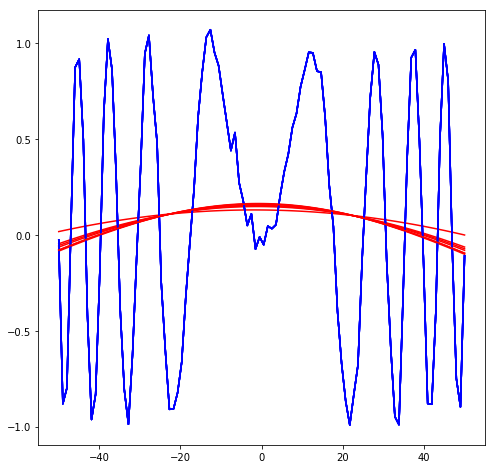

In [199]:
res = scipy.optimize.minimize(bandwidth_objective, n/2, args=(X,y,the_models,models.index), callback=plt_callback, options={"eps":1e-10}, bounds=((1,np.inf),))
res

In [221]:
for eps in range(10,0,-1):
    eps = 10**(-eps)
    new_band=n/5
    for i in range(100):
        kernel = local_models.local_models.GaussianKernel(bandwidth=new_band)
        j = 0
        _,the_models = models.transform(X.reshape(-1,1), weighted=True, kernel=kernel, r=kernel.support_radius(), return_models=True)
        res = scipy.optimize.minimize(bandwidth_objective, new_band, args=(X,y,the_models,models.index), callback=plt_callback, options={"eps":1e-6}, bounds=((0.01,np.inf),))
        print(res)
        new_band = res.x
        print(new_band)

      fun: 40.61016979203155
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.94875235e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.31628083])
[20.31628083]
      fun: 40.60912889962506
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.73443548e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.5501283])
[20.5501283]
      fun: 40.60858125552598
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.91322522e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.71655885])
[20.71655885]
      fun: 40.60831108507573
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.9475983e-08])
  message: b'CONVERGENCE: N

      fun: 40.60808200523019
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002276])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0288233])
[21.0288233]
      fun: 40.608081952385454
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022631])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0290535])
[21.0290535]
      fun: 40.60808190014311
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022501])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02928238])
[21.02928238]
      fun: 40.60808184849329
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022373])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=

      fun: 40.60808065536279
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019175])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03518796])
[21.03518796]
      fun: 40.608080617856366
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019066])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0353819])
[21.0353819]
      fun: 40.60808058077832
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018958])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03557472])
[21.03557472]
      fun: 40.608080544119645
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018849])
  message: b'CONVERGENCE: REL_REDUCTION_OF_

      fun: 40.608079697582724
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016149])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0405491])
[21.0405491]
      fun: 40.60807967097915
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016058])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.04071243])
[21.04071243]
      fun: 40.60807964467828
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015965])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.04087484])
[21.04087484]
      fun: 40.60807961867868
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015874])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F

      fun: 40.60808256818849
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00024096])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02644768])
[21.02644768]
      fun: 40.608082508956336
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002396])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02669139])
[21.02669139]
      fun: 40.60808245040096
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00023823])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0269337])
[21.0269337]
      fun: 40.60808239250653
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00023688])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_

      fun: 40.60808105498751
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020304])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0331864])
[21.0331864]
      fun: 40.60808101293728
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020188])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03339175])
[21.03339175]
      fun: 40.60808097136686
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020072])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03359591])
[21.03359591]
      fun: 40.60808093026791
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019958])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_

      fun: 40.608079981061486
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017101])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03886335])
[21.03886335]
      fun: 40.60807995123152
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017004])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03903629])
[21.03903629]
      fun: 40.60807992173885
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016907])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03920826])
[21.03920826]
      fun: 40.60807989258177
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016809])
  message: b'CONVERGENCE: REL_REDUCTION_OF

      fun: 40.60808319917315
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002551])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0239326])
[21.0239326]
      fun: 40.60808313278745
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025365])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02419062])
[21.02419062]
      fun: 40.60808306715527
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025221])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02444716])
[21.02444716]
      fun: 40.60808300226667
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025078])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<

      fun: 40.60808150300359
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021497])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03106712])
[21.03106712]
      fun: 40.60808145586475
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021376])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03128453])
[21.03128453]
      fun: 40.60808140925943
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021253])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03150072])
[21.03150072]
      fun: 40.608081363184574
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021132])
  message: b'CONVERGENCE: REL_REDUCTION_OF

      fun: 40.6080802989385
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018109])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03707823])
[21.03707823]
      fun: 40.60808026548889
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018005])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03726137])
[21.03726137]
      fun: 40.60808023241984
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017904])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03744347])
[21.03744347]
      fun: 40.608080199726814
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017801])
  message: b'CONVERGENCE: REL_REDUCTION_OF_

      fun: 40.61016979203155
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.94875235e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.31628083])
[20.31628083]
      fun: 40.60912889962506
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.73443548e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.5501283])
[20.5501283]
      fun: 40.60858125552598
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.91322522e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.71655885])
[20.71655885]
      fun: 40.60831108507573
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.9475983e-08])
  message: b'CONVERGENCE: N

      fun: 40.60808200523019
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002276])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0288233])
[21.0288233]
      fun: 40.608081952385454
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022631])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0290535])
[21.0290535]
      fun: 40.60808190014311
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022501])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02928238])
[21.02928238]
      fun: 40.60808184849329
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022373])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=

      fun: 40.60808065536279
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019175])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03518796])
[21.03518796]
      fun: 40.608080617856366
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019066])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0353819])
[21.0353819]
      fun: 40.60808058077832
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018958])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03557472])
[21.03557472]
      fun: 40.608080544119645
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018849])
  message: b'CONVERGENCE: REL_REDUCTION_OF_

      fun: 40.608079697582724
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016149])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0405491])
[21.0405491]
      fun: 40.60807967097915
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016058])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.04071243])
[21.04071243]
      fun: 40.60807964467828
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015965])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.04087484])
[21.04087484]
      fun: 40.60807961867868
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015874])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F

      fun: 40.60808256818849
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00024096])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02644768])
[21.02644768]
      fun: 40.608082508956336
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002396])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02669139])
[21.02669139]
      fun: 40.60808245040096
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00023823])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0269337])
[21.0269337]
      fun: 40.60808239250653
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00023688])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_

      fun: 40.60808105498751
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020304])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0331864])
[21.0331864]
      fun: 40.60808101293728
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020188])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03339175])
[21.03339175]
      fun: 40.60808097136686
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020072])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03359591])
[21.03359591]
      fun: 40.60808093026791
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019958])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_

      fun: 40.608079981061486
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017101])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03886335])
[21.03886335]
      fun: 40.60807995123152
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017004])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03903629])
[21.03903629]
      fun: 40.60807992173885
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016907])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03920826])
[21.03920826]
      fun: 40.60807989258177
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016809])
  message: b'CONVERGENCE: REL_REDUCTION_OF

      fun: 40.60808319917315
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002551])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0239326])
[21.0239326]
      fun: 40.60808313278745
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025365])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02419062])
[21.02419062]
      fun: 40.60808306715527
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025221])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02444716])
[21.02444716]
      fun: 40.60808300226667
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025078])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<

      fun: 40.60808150300359
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021497])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03106712])
[21.03106712]
      fun: 40.60808145586475
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021376])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03128453])
[21.03128453]
      fun: 40.60808140925943
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021253])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03150072])
[21.03150072]
      fun: 40.608081363184574
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021132])
  message: b'CONVERGENCE: REL_REDUCTION_OF

      fun: 40.6080802989385
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018109])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03707823])
[21.03707823]
      fun: 40.60808026548889
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018005])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03726137])
[21.03726137]
      fun: 40.60808023241984
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017904])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03744347])
[21.03744347]
      fun: 40.608080199726814
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017801])
  message: b'CONVERGENCE: REL_REDUCTION_OF_

      fun: 40.61016979203155
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.94875235e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.31628083])
[20.31628083]
      fun: 40.60912889962506
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.73443548e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.5501283])
[20.5501283]
      fun: 40.60858125552598
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.91322522e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.71655885])
[20.71655885]
      fun: 40.60831108507573
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.9475983e-08])
  message: b'CONVERGENCE: N

      fun: 40.60808200523019
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002276])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0288233])
[21.0288233]
      fun: 40.608081952385454
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022631])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0290535])
[21.0290535]
      fun: 40.60808190014311
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022501])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02928238])
[21.02928238]
      fun: 40.60808184849329
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022373])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=

      fun: 40.60808065536279
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019175])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03518796])
[21.03518796]
      fun: 40.608080617856366
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019066])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0353819])
[21.0353819]
      fun: 40.60808058077832
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018958])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03557472])
[21.03557472]
      fun: 40.608080544119645
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018849])
  message: b'CONVERGENCE: REL_REDUCTION_OF_

      fun: 40.608079697582724
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016149])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0405491])
[21.0405491]
      fun: 40.60807967097915
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016058])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.04071243])
[21.04071243]
      fun: 40.60807964467828
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015965])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.04087484])
[21.04087484]
      fun: 40.60807961867868
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015874])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F

      fun: 40.60808256818849
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00024096])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02644768])
[21.02644768]
      fun: 40.608082508956336
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002396])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02669139])
[21.02669139]
      fun: 40.60808245040096
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00023823])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0269337])
[21.0269337]
      fun: 40.60808239250653
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00023688])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_

      fun: 40.60808105498751
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020304])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0331864])
[21.0331864]
      fun: 40.60808101293728
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020188])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03339175])
[21.03339175]
      fun: 40.60808097136686
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00020072])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03359591])
[21.03359591]
      fun: 40.60808093026791
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019958])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_

      fun: 40.608079981061486
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017101])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03886335])
[21.03886335]
      fun: 40.60807995123152
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017004])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03903629])
[21.03903629]
      fun: 40.60807992173885
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016907])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03920826])
[21.03920826]
      fun: 40.60807989258177
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016809])
  message: b'CONVERGENCE: REL_REDUCTION_OF

      fun: 40.60808319917315
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002551])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0239326])
[21.0239326]
      fun: 40.60808313278745
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025365])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02419062])
[21.02419062]
      fun: 40.60808306715527
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025221])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02444716])
[21.02444716]
      fun: 40.60808300226667
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00025078])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<

      fun: 40.60808150300359
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021497])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03106712])
[21.03106712]
      fun: 40.60808145586475
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021376])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03128453])
[21.03128453]
      fun: 40.60808140925943
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021253])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03150072])
[21.03150072]
      fun: 40.608081363184574
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00021132])
  message: b'CONVERGENCE: REL_REDUCTION_OF

      fun: 40.6080802989385
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018109])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03707823])
[21.03707823]
      fun: 40.60808026548889
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018005])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03726137])
[21.03726137]
      fun: 40.60808023241984
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017904])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03744347])
[21.03744347]
      fun: 40.608080199726814
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00017801])
  message: b'CONVERGENCE: REL_REDUCTION_OF_

      fun: 40.61016979203155
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.94875235e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.31628083])
[20.31628083]
      fun: 40.60912889962506
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.73443548e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.5501283])
[20.5501283]
      fun: 40.60858125552598
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.91322522e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 3
   status: 0
  success: True
        x: array([20.71655885])
[20.71655885]
      fun: 40.60831108507573
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.9475983e-08])
  message: b'CONVERGENCE: N

      fun: 40.60808200523019
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002276])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0288233])
[21.0288233]
      fun: 40.608081952385454
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022631])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0290535])
[21.0290535]
      fun: 40.60808190014311
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022501])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.02928238])
[21.02928238]
      fun: 40.60808184849329
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00022373])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=

      fun: 40.60808065536279
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019175])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03518796])
[21.03518796]
      fun: 40.608080617856366
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00019066])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0353819])
[21.0353819]
      fun: 40.60808058077832
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018958])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.03557472])
[21.03557472]
      fun: 40.608080544119645
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00018849])
  message: b'CONVERGENCE: REL_REDUCTION_OF_

      fun: 40.608079697582724
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016149])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.0405491])
[21.0405491]
      fun: 40.60807967097915
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00016058])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.04071243])
[21.04071243]
      fun: 40.60807964467828
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015965])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 1
   status: 0
  success: True
        x: array([21.04087484])
[21.04087484]
      fun: 40.60807961867868
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00015874])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F

In [266]:
pairs = []
for strt_band in np.linspace(2*n,3*n,1):
    eps = 1e-8
    print(strt_band)
    new_band=strt_band
    for i in range(100):
        kernel = local_models.local_models.GaussianKernel(bandwidth=new_band)
        j = 0
        _,the_models = models.transform(X.reshape(-1,1), weighted=True, kernel=kernel, r=kernel.support_radius(), return_models=True)
        #res = scipy.optimize.minimize(bandwidth_objective, new_band, args=(X,y,the_models,models.index), callback=plt_callback, options={"eps":eps}, bounds=((0.01,np.inf),))
        res = scipy.optimize.minimize(bandwidth_objective, new_band, args=(X,y,the_models,models.index), options={"eps":eps}, bounds=((0.01,np.inf),))
        pairs.append((new_band, res.x))

        if res.x == new_band:
            break
        new_band = res.x


200.0


In [268]:
pairs = np.array(pairs)

In [269]:
pairs[:30]

array([[200.0, array([33.4038704])],
       [array([33.4038704]), array([26.59889716])],
       [array([26.59889716]), array([24.02352104])],
       [array([24.02352104]), array([22.78139545])],
       [array([22.78139545]), array([22.10971321])],
       [array([22.10971321]), array([21.7201967])],
       [array([21.7201967]), array([21.48407586])],
       [array([21.48407586]), array([21.33668958])],
       [array([21.33668958]), array([21.24296716])],
       [array([21.24296716]), array([21.18256353])],
       [array([21.18256353]), array([21.14344325])],
       [array([21.14344325]), array([21.11795043])],
       [array([21.11795043]), array([21.11766692])],
       [array([21.11766692]), array([21.11738484])],
       [array([21.11738484]), array([21.11710417])],
       [array([21.11710417]), array([21.11682493])],
       [array([21.11682493]), array([21.11654782])],
       [array([21.11654782]), array([21.11627142])],
       [array([21.11627142]), array([21.11599715])],
       [arra

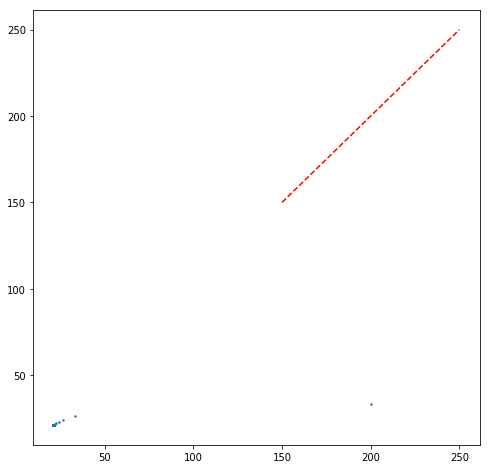

In [270]:
plt.scatter(pairs[:,0], pairs[:,1],s=2)
plt.plot(np.linspace(150,250,2), np.linspace(150,250,2),c='r',linestyle='--')

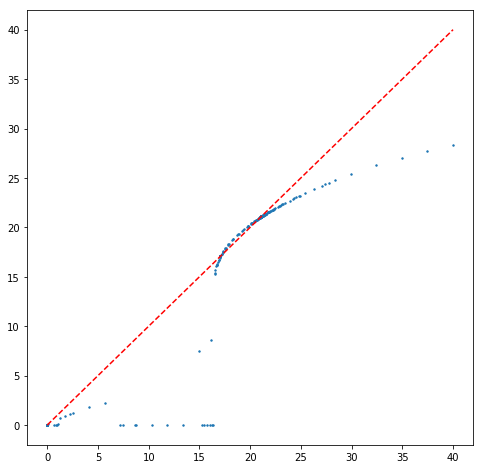

In [257]:
plt.scatter(pairs[:,0], pairs[:,1],s=2)
plt.plot(np.linspace(0,40,2), np.linspace(0,40,2),c='r',linestyle='--')
plt.savefig(os.path.join(project_dir, "transition_plot.png"))

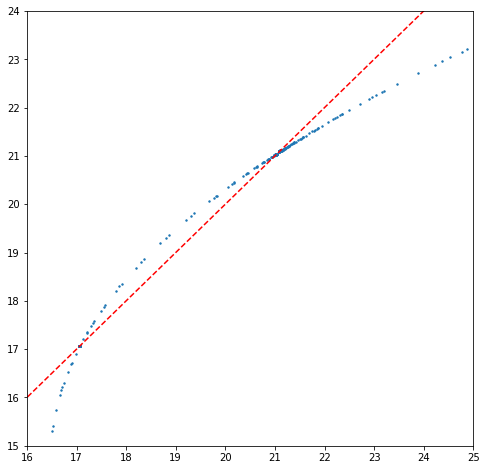

In [256]:
plt.scatter(pairs[:,0], pairs[:,1],s=2)
plt.plot(np.linspace(0,40,2), np.linspace(0,40,2),c='r',linestyle='--')
plt.xlim(16,25)
plt.ylim(15,24)
plt.savefig(os.path.join(project_dir, "transition_plot_zoom.png"))